In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iteration4_docs').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

In [2]:
fwData = spark.read.csv("Datasets/FoodWasteDataFAO.csv", inferSchema=True, header=True)

In [3]:
fwData.printSchema()

root
 |-- geographicaream49: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- measureditemcpc: string (nullable = true)
 |-- crop: string (nullable = true)
 |-- timepointyears: string (nullable = true)
 |-- loss_per_clean: string (nullable = true)
 |-- percentage_loss_of_quantity: string (nullable = true)
 |-- loss_quantity: string (nullable = true)
 |-- loss_qualitiative: string (nullable = true)
 |-- loss_monetary: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- fsc_location1: string (nullable = true)
 |-- periodofstorage: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- causeofloss: string (nullable = true)
 |-- samplesize: string (nullable = true)
 |-- units: string (nullable = true)
 |-- method_datacollection: string (nullable = true)
 |-- tag_datacollection: string (nullable = true)
 |-- reference: string (nullable = true)
 |-- url: string (nullable = true)



In [4]:
fwData.head()

Row(geographicaream49='100', country='Bulgaria', region=None, measureditemcpc='0111', crop='wheat', timepointyears='2000', loss_per_clean='1.7978', percentage_loss_of_quantity=None, loss_quantity=None, loss_qualitiative=None, loss_monetary=None, activity=None, fsc_location1='Total Supply Chain Estimate', periodofstorage=None, treatment=None, causeofloss=None, samplesize=None, units=None, method_datacollection=None, tag_datacollection='Food Balance Sheet/Ag. Production Questionnaire', reference=None, url=None)

In [5]:
for item in fwData.head():
    print(item)

100
Bulgaria
None
0111
wheat
2000
1.7978
None
None
None
None
None
Total Supply Chain Estimate
None
None
None
None
None
None
Food Balance Sheet/Ag. Production Questionnaire
None
None


In [6]:
from pyspark.sql.functions import isnan,isnull, when, count, col
fwData.select([count(when(isnull(c), c)).alias(c) for c in fwData.columns]).show()

+-----------------+-------+------+---------------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+-------------+---------------+---------+-----------+----------+-----+---------------------+------------------+---------+-----+
|geographicaream49|country|region|measureditemcpc|crop|timepointyears|loss_per_clean|percentage_loss_of_quantity|loss_quantity|loss_qualitiative|loss_monetary|activity|fsc_location1|periodofstorage|treatment|causeofloss|samplesize|units|method_datacollection|tag_datacollection|reference|  url|
+-----------------+-------+------+---------------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+-------------+---------------+---------+-----------+----------+-----+---------------------+------------------+---------+-----+
|                0|    249| 17865|             57|  50|           121|          1188|                      12326|  

In [7]:
fwData.select([count(when(isnan(c), c)).alias(c) for c in fwData.columns]).show()

+-----------------+-------+------+---------------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+-------------+---------------+---------+-----------+----------+-----+---------------------+------------------+---------+---+
|geographicaream49|country|region|measureditemcpc|crop|timepointyears|loss_per_clean|percentage_loss_of_quantity|loss_quantity|loss_qualitiative|loss_monetary|activity|fsc_location1|periodofstorage|treatment|causeofloss|samplesize|units|method_datacollection|tag_datacollection|reference|url|
+-----------------+-------+------+---------------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+-------------+---------------+---------+-----------+----------+-----+---------------------+------------------+---------+---+
|                0|      0|     0|              0|   0|             0|             0|                          0|        

In [8]:
selected_fwData = fwData.select(['geographicaream49','country', 'region', 'crop', 'timepointyears', 
                               'loss_per_clean', 'percentage_loss_of_quantity', 'loss_quantity',
                               'loss_qualitiative', 'loss_monetary', 'activity'])

In [9]:
selected_fwData.printSchema()

root
 |-- geographicaream49: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- crop: string (nullable = true)
 |-- timepointyears: string (nullable = true)
 |-- loss_per_clean: string (nullable = true)
 |-- percentage_loss_of_quantity: string (nullable = true)
 |-- loss_quantity: string (nullable = true)
 |-- loss_qualitiative: string (nullable = true)
 |-- loss_monetary: string (nullable = true)
 |-- activity: string (nullable = true)



In [10]:
renamed_fwData = selected_fwData.withColumnRenamed("geographicaream49", "geographicarea")
renamed_fwData.printSchema()

root
 |-- geographicarea: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- crop: string (nullable = true)
 |-- timepointyears: string (nullable = true)
 |-- loss_per_clean: string (nullable = true)
 |-- percentage_loss_of_quantity: string (nullable = true)
 |-- loss_quantity: string (nullable = true)
 |-- loss_qualitiative: string (nullable = true)
 |-- loss_monetary: string (nullable = true)
 |-- activity: string (nullable = true)



In [11]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

renamed_fwData.select("crop").show(2)

allColNames = renamed_fwData.columns
for colName in allColNames:
    renamed_fwData = renamed_fwData.withColumn(colName, regexp_replace(colName, "[,]", ""))
    renamed_fwData = renamed_fwData.withColumn(colName, regexp_replace(colName, "[-]", ""))
    renamed_fwData = renamed_fwData.withColumn(colName, regexp_replace(colName, "[/]", ""))
    renamed_fwData = renamed_fwData.withColumn(colName, regexp_replace(colName, '["]', ""))
    renamed_fwData = renamed_fwData.withColumn(colName, regexp_replace(colName, "[(]", ""))
    renamed_fwData = renamed_fwData.withColumn(colName, regexp_replace(colName, "[)]", ""))

renamed_fwData.select("crop").show(2)

+--------------------+
|                crop|
+--------------------+
|               wheat|
|groundnuts, exclu...|
+--------------------+
only showing top 2 rows

+--------------------+
|                crop|
+--------------------+
|               wheat|
|groundnuts exclud...|
+--------------------+
only showing top 2 rows



In [12]:
changedType_fwData = renamed_fwData.withColumn("geographicarea", renamed_fwData["geographicarea"]
                                               .cast(IntegerType())).withColumn("timepointyears", renamed_fwData["timepointyears"]
                                               .cast(IntegerType())).withColumn("loss_per_clean", renamed_fwData["loss_per_clean"]
                                               .cast(IntegerType())).withColumn("percentage_loss_of_quantity", renamed_fwData["percentage_loss_of_quantity"]
                                               .cast(IntegerType())).withColumn("loss_quantity", renamed_fwData["loss_quantity"]
                                               .cast(IntegerType()))

changedType_fwData.printSchema()

root
 |-- geographicarea: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- crop: string (nullable = true)
 |-- timepointyears: integer (nullable = true)
 |-- loss_per_clean: integer (nullable = true)
 |-- percentage_loss_of_quantity: integer (nullable = true)
 |-- loss_quantity: integer (nullable = true)
 |-- loss_qualitiative: string (nullable = true)
 |-- loss_monetary: string (nullable = true)
 |-- activity: string (nullable = true)



In [13]:
changedType_fwData.select([count(when(isnull(c), c)).alias(c) for c in changedType_fwData.columns]).show()

+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+
|geographicarea|country|region|crop|timepointyears|loss_per_clean|percentage_loss_of_quantity|loss_quantity|loss_qualitiative|loss_monetary|activity|
+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+
|           111|    249| 17865|  50|           141|          1207|                      12522|        16856|            18471|        18487|   15958|
+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+



In [14]:
droppedNull_fwData = changedType_fwData.dropna(how='any', subset=('geographicarea','country','crop','timepointyears'))
droppedNull_fwData.select([count(when(isnull(c), c)).alias(c) for c in droppedNull_fwData.columns]).show()

+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+
|geographicarea|country|region|crop|timepointyears|loss_per_clean|percentage_loss_of_quantity|loss_quantity|loss_qualitiative|loss_monetary|activity|
+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+
|             0|      0| 17608|   0|             0|          1065|                      12155|        16489|            18135|        18141|   15593|
+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+



In [15]:
percentage_loss_val = droppedNull_fwData.select(mean(droppedNull_fwData.percentage_loss_of_quantity)).collect()
loss_per_clean_val = droppedNull_fwData.select(mean(droppedNull_fwData.loss_per_clean)).collect()
loss_quantity_val = droppedNull_fwData.select(mean(droppedNull_fwData.loss_quantity)).collect()

percentage_loss_mean = percentage_loss_val[0][0]
loss_per_clean_mean = loss_per_clean_val[0][0]
loss_quantity_mean = loss_quantity_val[0][0]

droppedNull_fwData.select('percentage_loss_of_quantity', 'loss_per_clean', 'loss_quantity').show(2)

droppedNull_fwData = droppedNull_fwData.fillna(percentage_loss_mean, subset=['percentage_loss_of_quantity'])
droppedNull_fwData = droppedNull_fwData.fillna(loss_per_clean_mean, subset=['loss_per_clean'])
droppedNull_fwData = droppedNull_fwData.fillna(loss_quantity_mean, subset=['loss_quantity'])

droppedNull_fwData.select('percentage_loss_of_quantity', 'loss_per_clean', 'loss_quantity').show(2)

+---------------------------+--------------+-------------+
|percentage_loss_of_quantity|loss_per_clean|loss_quantity|
+---------------------------+--------------+-------------+
|                       null|             1|         null|
|                       null|             5|         null|
+---------------------------+--------------+-------------+
only showing top 2 rows

+---------------------------+--------------+-------------+
|percentage_loss_of_quantity|loss_per_clean|loss_quantity|
+---------------------------+--------------+-------------+
|                         45|             1|       143336|
|                         45|             5|       143336|
+---------------------------+--------------+-------------+
only showing top 2 rows



In [16]:
final_fwData = droppedNull_fwData.fillna('missing', subset=['region', 'loss_qualitiative', 'loss_monetary', 'activity'])

final_fwData.select([count(when(isnull(c), c)).alias(c) for c in final_fwData.columns]).show()

+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+
|geographicarea|country|region|crop|timepointyears|loss_per_clean|percentage_loss_of_quantity|loss_quantity|loss_qualitiative|loss_monetary|activity|
+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+
|             0|      0|     0|   0|             0|             0|                          0|            0|                0|            0|       0|
+--------------+-------+------+----+--------------+--------------+---------------------------+-------------+-----------------+-------------+--------+



In [17]:
final_fwData = final_fwData.withColumn("id", monotonically_increasing_id())
final_fwData.printSchema()

root
 |-- geographicarea: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = false)
 |-- crop: string (nullable = true)
 |-- timepointyears: integer (nullable = true)
 |-- loss_per_clean: integer (nullable = true)
 |-- percentage_loss_of_quantity: integer (nullable = true)
 |-- loss_quantity: integer (nullable = true)
 |-- loss_qualitiative: string (nullable = false)
 |-- loss_monetary: string (nullable = false)
 |-- activity: string (nullable = false)
 |-- id: long (nullable = false)



In [18]:
final_fwData.select("id").show(10)

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+
only showing top 10 rows



In [19]:
final_fwData = final_fwData.select(["id", "geographicarea", "country", 
                                   "region", "crop", "timepointyears", 
                                   "loss_per_clean", "percentage_loss_of_quantity", "loss_quantity",
                                   "loss_qualitiative", "loss_monetary", "activity"])
final_fwData.printSchema()

root
 |-- id: long (nullable = false)
 |-- geographicarea: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = false)
 |-- crop: string (nullable = true)
 |-- timepointyears: integer (nullable = true)
 |-- loss_per_clean: integer (nullable = true)
 |-- percentage_loss_of_quantity: integer (nullable = true)
 |-- loss_quantity: integer (nullable = true)
 |-- loss_qualitiative: string (nullable = false)
 |-- loss_monetary: string (nullable = false)
 |-- activity: string (nullable = false)



In [20]:
print("No of rows before reduction: " , final_fwData.count())

final_fwData_reduced = final_fwData.filter(final_fwData.id < 15000)

print("No of rows after reduction: " ,final_fwData_reduced.count())

No of rows before reduction:  18174
No of rows after reduction:  15000


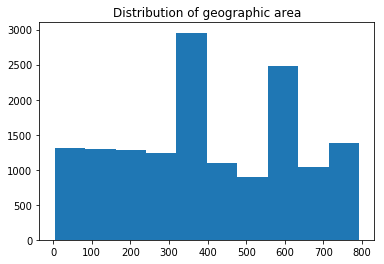

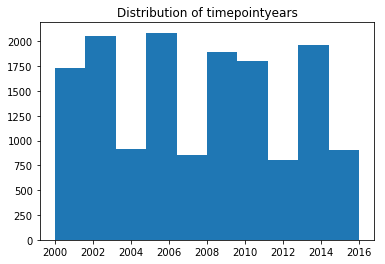

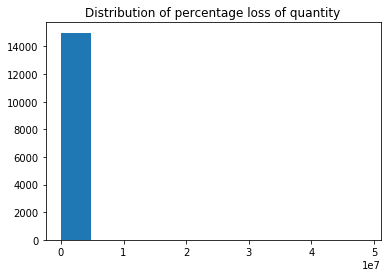

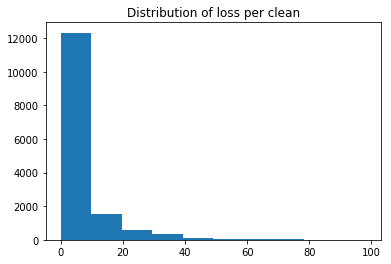

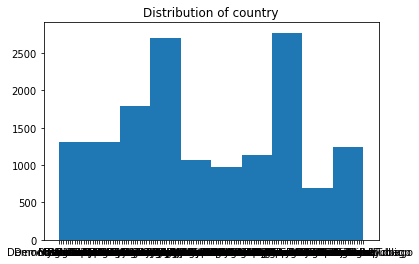

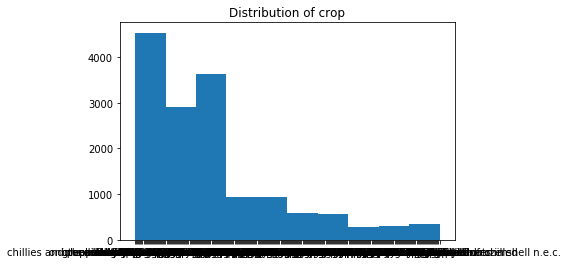

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

geographicareaArray = np.array(final_fwData_reduced.select('geographicarea').collect())
plt.hist(geographicareaArray)
plt.title("Distribution of geographic area")
plt.show()

timepointyearsArray = np.array(final_fwData_reduced.select('timepointyears').collect())
plt.hist(timepointyearsArray)
plt.title("Distribution of timepointyears")
plt.show()

percentageLossArray = np.array(final_fwData_reduced.select('loss_quantity').collect())
plt.hist(percentageLossArray)
plt.title("Distribution of percentage loss of quantity")
plt.show()

lossPerCleanArray = np.array(final_fwData_reduced.select('loss_per_clean').collect())
plt.hist(lossPerCleanArray)
plt.title("Distribution of loss per clean")
plt.show()

CountryArray = np.array(final_fwData_reduced.select('country').collect())
plt.hist(CountryArray)
plt.title("Distribution of country")
plt.show()

CropArray = np.array(final_fwData_reduced.select('crop').collect())
plt.hist(CropArray)
plt.title("Distribution of crop")
plt.show()

In [47]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["timepointyears", "loss_per_clean"],
    outputCol="features")

transformed = assembler.transform(final_fwData_reduced)
final_Data = transformed.select("features", "geographicarea")

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(final_Data)

(trainingFwData, testFwData) = final_Data.randomSplit([0.7, 0.3])
print("size of training data: ", trainingFwData.count())
print("size of test data: ", testFwData.count())

size of training data:  10606
size of test data:  4394


In [48]:
rf = RandomForestRegressor(featuresCol="features", labelCol="geographicarea")

pipeline = Pipeline(stages=[featureIndexer, rf])

model = pipeline.fit(final_Data)

predictions = model.transform(testFwData)

predictions.select("prediction", "geographicarea", "features").show(5)

+-----------------+--------------+------------+
|       prediction|geographicarea|    features|
+-----------------+--------------+------------+
|374.7879221240195|           112|[2000.0,0.0]|
|374.7879221240195|           112|[2000.0,0.0]|
|374.7879221240195|           124|[2000.0,0.0]|
|374.7879221240195|           124|[2000.0,0.0]|
|374.7879221240195|           124|[2000.0,0.0]|
+-----------------+--------------+------------+
only showing top 5 rows



In [49]:
evaluator = RegressionEvaluator(
    labelCol="geographicarea", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

totalResults = predictions.select('geographicarea','prediction')

correctResults = totalResults.filter(totalResults['geographicarea'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

Root Mean Squared Error (RMSE) on test data = 209.079
Correct: 4394
Total Correct: 0


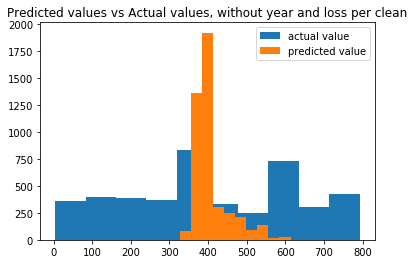

In [50]:
predictionArray = np.array(predictions.select('prediction').collect())
geographicAreaArray = np.array(predictions.select('geographicarea').collect())
plt.hist(geographicAreaArray, label="actual value")
plt.hist(predictionArray, label="predicted value")
plt.title("Predicted values vs Actual values, without year and loss per clean")
plt.legend(loc='upper right')
plt.show()